In [24]:
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.mps as mps
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [25]:
def get_default_device():
    cuda = torch.cuda.is_available()
    mps = torch.backends.mps.is_available()
    print(cuda, mps)

    if cuda:
        return torch.device("cuda")
    if mps:
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [26]:
device = get_default_device()
device

False True


device(type='mps')

In [27]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [28]:
# 1. 데이터 로드 및 전처리
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [29]:
data_dir = "/Users/mks/Documents/GitHub/AI/archive"
os.listdir(data_dir)

['fer20131.csv', '.DS_Store', 'train', 'ferSubmission.csv', 'val']

In [30]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

# 경로를 자신의 데이터셋 위치로 변경

image_datasets = {
    x: ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes


In [31]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x176441790>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x3260a6290>}

In [32]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 2913, 'val': 998}

In [33]:
# 2. ResNet18 모델 로드 및 수정
num_classes = len(class_names)

In [34]:
# Pretrained ResNet18 로드
resnet18 = models.resnet18(pretrained=True)

# 마지막 레이어 교체
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 3. ResNet9 가중치 불러오기
resnet9_weights_path = "/Users/mks/Documents/GitHub/AI/model/ResNet9_epoch-100_score-0.8633.pth"
resnet9_weights = torch.load(resnet9_weights_path, map_location=torch.device("cpu"))


/var/folders/_w/6twp845j1tsgpylfv57d8d2r0000gn/T/ipykernel_12282/134002518.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet9_weights = torch.load(resnet9_weights_p

In [35]:
# 필요한 레이어의 가중치만 ResNet18에 초기화
# (layer1, layer2 등 공유 가능한 가중치만 가져옵니다)
resnet18_state_dict = resnet18.state_dict()
resnet18_state_dict.update({
    k: v for k, v in resnet9_weights.items() if k in resnet18_state_dict
})
resnet18.load_state_dict(resnet18_state_dict, strict=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
resnet18 = resnet18.to(device)

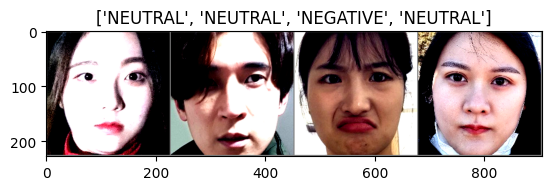

In [36]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## Training

In [37]:
# 4. 학습 준비
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
# 5. 학습 함수
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, save_path="best_model.pth"):
    """
    모델을 학습하고, validation accuracy가 향상될 때마다 모델을 저장합니다.

    Args:
        model: 학습할 모델 객체.
        dataloaders: train과 val 데이터셋을 포함하는 딕셔너리.
        criterion: 손실 함수.
        optimizer: 최적화 함수.
        scheduler: 학습률 스케줄러.
        num_epochs: 총 학습 epoch 수.
        save_path: 모델을 저장할 경로.

    Returns:
        학습된 모델 객체.
    """
    best_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Validation phase에서 모델 저장
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()  # 가중치 복사
                torch.save(model.state_dict(), save_path)  # 모델 저장
                print(f"*** Best model saved with accuracy: {best_acc:.4f} ***")

        scheduler.step()
        print()

    # Best 가중치 로드
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

    return model


In [39]:
# 6. 학습 시작
resnet18 = train_model(
    model=resnet18,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    save_path="/Users/mks/Documents/GitHub/AI/model/ResNet18_best.pth"
)

Epoch 1/50
----------
train Loss: 0.3001 Acc: 0.8857
val Loss: 0.2587 Acc: 0.9148
*** Best model saved with accuracy: 0.9148 ***

Epoch 2/50
----------
train Loss: 0.0682 Acc: 0.9753
val Loss: 0.2100 Acc: 0.9299
*** Best model saved with accuracy: 0.9299 ***

Epoch 3/50
----------
train Loss: 0.0490 Acc: 0.9842
val Loss: 0.2398 Acc: 0.9289

Epoch 4/50
----------
train Loss: 0.0414 Acc: 0.9894
val Loss: 0.3132 Acc: 0.9158

Epoch 5/50
----------
train Loss: 0.0257 Acc: 0.9924
val Loss: 0.2649 Acc: 0.9178

Epoch 6/50
----------
train Loss: 0.0156 Acc: 0.9955
val Loss: 0.3267 Acc: 0.9168

Epoch 7/50
----------
train Loss: 0.0171 Acc: 0.9949
val Loss: 0.3470 Acc: 0.9108

Epoch 8/50
----------
train Loss: 0.0134 Acc: 0.9959
val Loss: 0.3335 Acc: 0.9158

Epoch 9/50
----------
train Loss: 0.0068 Acc: 0.9993
val Loss: 0.2777 Acc: 0.9279

Epoch 10/50
----------
train Loss: 0.0074 Acc: 0.9983
val Loss: 0.2836 Acc: 0.9259

Epoch 11/50
----------
train Loss: 0.0055 Acc: 0.9986
val Loss: 0.2967 Acc: